In [1]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, normalize, MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import chi2_contingency

### Load data

In [2]:
df = pd.read_csv('result_after.csv')
df = df.dropna()
X = df.loc[:, df.columns != 'won']
y = df['won']
X = X.drop(['innings_x', 'innings_y', 'overs', 'runs', 'scorecard_no', 'season', 'country_won' ], axis=1)

#### Label encoder

In [3]:
labelencoder = LabelEncoder()
label_col = ['ground', 'countries', 'bat_first_country', 'field_first_country']
X[label_col] = X[label_col].apply(LabelEncoder().fit_transform)

### Chi-squared test
Have 2 approaches
1. make a cross table, create contingency table
2. use scipy with chi2_contingency <br>
Now, use second approach

#### 1. outcome - home ground

In [12]:
# make cross table with outcome and homeground, we can do more about other variable as well
import scipy.stats as stats

data_crosstab = pd.crosstab(X['team_no'],
                            y,
                           margins=True, margins_name="Total")
data_crosstab

won,0,1,2,Total
team_no,,,,
1,673,1054,781,2508
2,1054,673,776,2503
Total,1727,1727,1557,5011


In [23]:
chi_square = 0
rows = X['team_no'].unique()
columns = y.unique()
# print(rows)
# print(columns)
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        # print(i,j)
        # print(O)
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

In [28]:
# significance level
def chi_square_cal():
    alpha = 0.05

    # Calcualtion of Chisquare
    chi_square = 0
    rows = X['team_no'].unique()
    columns = y.unique()
    for i in columns:
        for j in rows:
            O = data_crosstab[i][j]
            # print(i,j)
            # print(O)
            E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
            chi_square += (O-E)**2/E

    # The p-value approach
    print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
    p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    conclusion = "Failed to reject the null hypothesis."
    if p_value <= alpha:
        conclusion = "Null Hypothesis is rejected."
            
    print("chisquare-score is:", chi_square, " and p value is:", p_value)
    print(conclusion)
        
    # The critical value approach
    print("\n--------------------------------------------------------------------------------------")
    print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
    critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
    conclusion = "Failed to reject the null hypothesis."
    if chi_square > critical_value:
        conclusion = "Null Hypothesis is rejected."
            
    print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
    print(conclusion)

In [27]:

from scipy.stats import chi2_contingency
 
# defining the table, get it from cross table
# data
stat, p, dof, expected = chi2_contingency(data_crosstab)
 
# interpret p-value
alpha = 0.05
print("p-value is " + str(p))
if p <= alpha:
    print('Null Hypothesis is rejected.')
else:
    print("Failed to reject the null hypothesis.")

print('Expected value: ', expected)
print('Degree of freedom: ', dof)
print('chi-squeared score: ', stat)

p-value is 1.1269696662366099e-33
Null Hypothesis is rejected.
Expected value:  [[ 864.36160447  864.36160447  779.27679106 2508.        ]
 [ 862.63839553  862.63839553  777.72320894 2503.        ]
 [1727.         1727.         1557.         5011.        ]]
Degree of freedom:  6
chi-squeared score:  168.118936092428


### Multinomial Logistic regression

In [33]:
X_mnl_train, X_mnl_test, y_mnl_train, y_mnl_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [34]:
X_mnl_train = sm.add_constant(X_mnl_train)
mnl_log_reg_model = sm.MNLogit(y_mnl_train, X_mnl_train)
mnl_log_reg_model = mnl_log_reg_model.fit()
print(mnl_log_reg_model.summary())

Optimization terminated successfully.
         Current function value: 0.686289
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                    won   No. Observations:                 3507
Model:                        MNLogit   Df Residuals:                     3475
Method:                           MLE   Df Model:                           30
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.3746
Time:                        22:54:30   Log-Likelihood:                -2406.8
converged:                       True   LL-Null:                       -3848.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  won=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.2842      0.422      0.674      0.500      -0.542   

In [52]:
# X_mnl_train = X_mnl_train.drop(['const'], axis=1)

#### Probability of Predicted outcome

In [53]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
# fit the model on the whole dataset
model.fit(X_mnl_train, y_mnl_train)
# predict a multinomial probability distribution
yhat_prob = model.predict_proba(X_mnl_test)
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhat_prob[0])
print(yhat_prob)

Predicted Probabilities: [0.95865062 0.02394909 0.01740028]
[[0.95865062 0.02394909 0.01740028]
 [0.29824862 0.39027372 0.31147766]
 [0.13909901 0.39402653 0.46687446]
 ...
 [0.00825486 0.69484541 0.29689973]
 [0.03115468 0.24035242 0.72849291]
 [0.06590376 0.75794126 0.17615499]]


#### Predicted Class outcome

In [49]:
# predict the class label
yhat = model.predict(X_mnl_test)
# summarize the predicted class
print('Predicted Class: %d' % yhat[0])
print(yhat)

Predicted Class: 0
[0 1 2 ... 1 2 1]


Confusion Matrix

[[385  48  77]
 [ 54 390  82]
 [109 104 255]]

Accuracy: 0.68


Classification Report

              precision    recall  f1-score   support

     Lost: 0       0.70      0.75      0.73       510
      Won: 1       0.72      0.74      0.73       526
    Drawn: 2       0.62      0.54      0.58       468

    accuracy                           0.68      1504
   macro avg       0.68      0.68      0.68      1504
weighted avg       0.68      0.68      0.68      1504



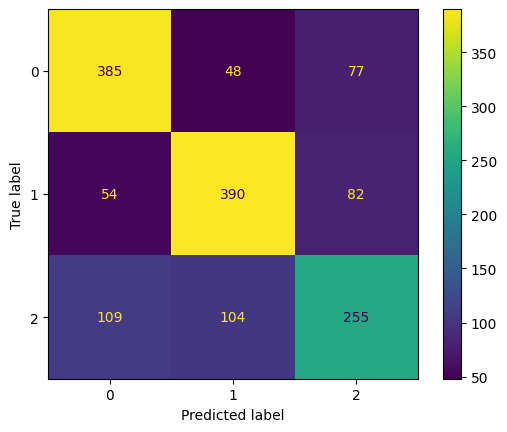

In [65]:
# from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

confusion = confusion_matrix(y_mnl_test, yhat)
print('Confusion Matrix\n')
print(confusion)
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_mnl_test, yhat)))

print('\nClassification Report\n')
print(classification_report(y_mnl_test, yhat, target_names=['Lost: 0', 'Won: 1', 'Drawn: 2']))

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion)
cm_display.plot()
plt.show()
